In [1]:
%%sh
rm -rf /tmp/dds
rm -rf /tmp/*png

In [2]:
# Adaptation of https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn
import logging
logging.basicConfig(level=logging.INFO)
import sklearn
import pandas as pd
import dds

import numpy as np
import pandas as pd
 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import requests
import io
import json


In [3]:
%%sh
ls -la /tmp/dds

total 0
drwxr-xr-x 1 ubuntu ubuntu 4096 Oct 10 13:20 .
drwxrwxrwt 1 root   root   4096 Oct 10 13:20 ..
drwxr-xr-x 1 ubuntu ubuntu 4096 Oct 10 13:20 data
drwxr-xr-x 1 ubuntu ubuntu 4096 Oct 10 13:20 internal


In [4]:
path_model = "/wine-quality/my_model"
path_model_stats = "/wine-quality/my_model_stats.json"

@dds.dds_function("/wine-quality/raw")
def data():
    print("*** in _load_data ***")
    url = "https://raw.githubusercontent.com/zygmuntz/wine-quality/master/winequality/winequality-red.csv"
    x = requests.get(url=url, verify=False).content 
    return pd.read_csv(io.StringIO(x.decode('utf8')), sep=";")


INFO:dds._api:Interaction tree:
INFO:dds._api:`- Fun <__main__.data> /wine-quality/raw <- *0af659b1a6
INFO:dds._api:   `- Ctx None
INFO:dds._api:Stage analysis: 0.234 sec 100.00%
INFO:dds._api:Stage store_inspect: 0.000 sec 0.00%
INFO:dds._api:Stage eval: 0.000 sec 0.00%
INFO:dds._api:Stage store_commit: 0.000 sec 0.00%
INFO:dds._api:Stage path_commit: 0.000 sec 0.00%


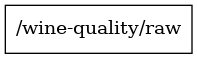

In [5]:
dds.eval(data, dds_export_graph="/tmp/2.png", dds_extra_debug=True, dds_stages=["analysis"])
from IPython.display import Image
Image("/tmp/2.png")

In [6]:
data().head(3)

INFO:dds._api:Interaction tree:
INFO:dds._api:`- Fun <__main__.data> /wine-quality/raw <- *0af659b1a6
INFO:dds._api:   `- Ctx None
INFO:dds._api:_eval_new_ctx:Evaluating (eval) fun <function data at 0x7f57d96e1310> with args [] kwargs OrderedDict()


*** in _load_data ***


/home/ubuntu/miniconda/envs/dds/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nl-userproxy-access.net.abnamro.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dds._api:_eval_new_ctx:Evaluating (eval) fun <function data at 0x7f57d96e1310>: completed
INFO:dds._api:_eval:Storing blob into key 0af659b1a61a8bc462525030bd375a7083587a5921ced0aa71c81bad78a4128b
INFO:dds.codec:Loading pandas codecs
INFO:dds.store:Link /tmp/dds/data/wine-quality/raw -> /tmp/dds/internal/blobs/0af659b1a61a8bc462525030bd375a7083587a5921ced0aa71c81bad78a4128b
INFO:dds._api:Stage analysis: 0.020 sec 2.42%
INFO:dds._api:Stage store_inspect: 0.000 sec 0.00%
INFO:dds._api:Stage eval: 0.691 sec 84.44%
INFO:dds._api:Stage store_commit: 0.103 sec 12.59%
INFO:dds._api:Stage path_commit: 0.005 sec 0.55%


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [7]:
def build_model(X_train, y_train):
    print("*** in build_model ***")
    pipeline = make_pipeline(preprocessing.StandardScaler(), 
                             RandomForestRegressor(n_estimators=100))
    hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                      'randomforestregressor__max_depth': [None, 5, 3, 1]}

    clf = GridSearchCV(pipeline, hyperparameters, cv=10)
    
    clf.fit(X_train, y_train)
    return clf
 
    
def model_stats(clf, X_test, y_test) -> str:
    print("*** in model_stats ***")
    pred = clf.predict(X_test)
    return json.dumps({
#         "r2_score": r2_score(y_test, pred),
        "mse": mean_squared_error(y_test, pred)
    })
    
    
def pipeline():
    wine_data = data()
    y = wine_data.quality
    X = wine_data.drop('quality', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.15, 
                                                        random_state=123, 
                                                        stratify=y)
    clf = dds.keep(path_model, build_model, X_train, y_train)
    dds.keep(path_model_stats, model_stats, clf, X_test, y_test)
    print("*** done ***")


# dds.eval(pipeline, dds_export_graph="1.png")


In [8]:
%%sh
# cat /tmp/data/wine-quality/my_model_stats.json

INFO:dds._api:Interaction tree:
INFO:dds._api:`- Fun <__main__.f> @ 74b41a0504
INFO:dds._api:   |- Ctx None
INFO:dds._api:   |- Fun <__main__.f4> /p4 <- *f609f1b0e3
INFO:dds._api:   |  `- Ctx 0ba3d60391
INFO:dds._api:   `- Fun <__main__.f3> /p3 <- *92cf83be00
INFO:dds._api:      |- Ctx 0924e5971c
INFO:dds._api:      |- Fun <__main__.f1> /p1 <- *545aff11a9
INFO:dds._api:      |  `- Ctx 209b35c622
INFO:dds._api:      `- Fun <__main__.f2> /p2 <- *8437be3b61
INFO:dds._api:         |- Ctx da14d7d9b2
INFO:dds._api:         `- ~~Fun <__main__.f1> /p1 <- *545aff11a9
INFO:dds._api:Stage analysis: 0.338 sec 100.00%
INFO:dds._api:Stage store_inspect: 0.000 sec 0.00%
INFO:dds._api:Stage eval: 0.000 sec 0.00%
INFO:dds._api:Stage store_commit: 0.000 sec 0.00%
INFO:dds._api:Stage path_commit: 0.000 sec 0.00%


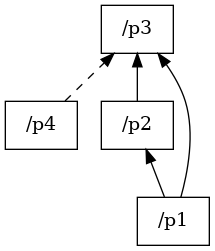

In [9]:

@dds.dds_function("/p1")
def f1(): return 2 

@dds.dds_function("/p2")
def f2(): return 2 + f1()

@dds.dds_function("/p3")
def f3(): return 1 + f1() + f2()

@dds.dds_function("/p4")
def f4(): return 1


def f():
    f4()
    f3()

dds.eval(f, dds_export_graph="/tmp/2.png", dds_extra_debug=True, dds_stages=["analysis"])
from IPython.display import Image
Image("/tmp/2.png")

In [10]:
f()

INFO:dds._api:Interaction tree:
INFO:dds._api:`- Fun <__main__.f4> /p4 <- *f609f1b0e3
INFO:dds._api:   `- Ctx None
INFO:dds._api:_eval_new_ctx:Evaluating (eval) fun <function f4 at 0x7f57d96e1040> with args [] kwargs OrderedDict()
INFO:dds._api:_eval_new_ctx:Evaluating (eval) fun <function f4 at 0x7f57d96e1040>: completed
INFO:dds._api:_eval:Storing blob into key f609f1b0e386e086668e9d1a7d1cb350deb15aea650f8981e85a163d379af9af
INFO:dds.store:Link /tmp/dds/data/p4 -> /tmp/dds/internal/blobs/f609f1b0e386e086668e9d1a7d1cb350deb15aea650f8981e85a163d379af9af
INFO:dds._api:Stage analysis: 0.020 sec 62.15%
INFO:dds._api:Stage store_inspect: 0.000 sec 0.00%
INFO:dds._api:Stage eval: 0.002 sec 7.01%
INFO:dds._api:Stage store_commit: 0.006 sec 18.73%
INFO:dds._api:Stage path_commit: 0.004 sec 12.12%
INFO:dds._api:Interaction tree:
INFO:dds._api:`- Fun <__main__.f3> /p3 <- *92cf83be00
INFO:dds._api:   |- Ctx None
INFO:dds._api:   |- Fun <__main__.f1> /p1 <- *545aff11a9
INFO:dds._api:   |  `- Ctx 